<img src="https://blogs.iadb.org/energia/wp-content/uploads/sites/16/2020/04/Oil-price-market-2.jpg" style="width:100%;">

#AI-Driven Price Forecasting for Oil
We have a comprehensive dataset of worldwide crude oil prices starting from 1983, which includes both the price changes and their corresponding percentage changes over time. This historical data provides a valuable foundation for developing a forecasting solution aimed at predicting oil prices for the upcoming 18 months, enabling better demand planning and market analysis.

#1. SETUP AND REPRODUCIBILITY

In [94]:
import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


#2. DATA LOADING AND EXPLORATION

<Axes: xlabel='date'>

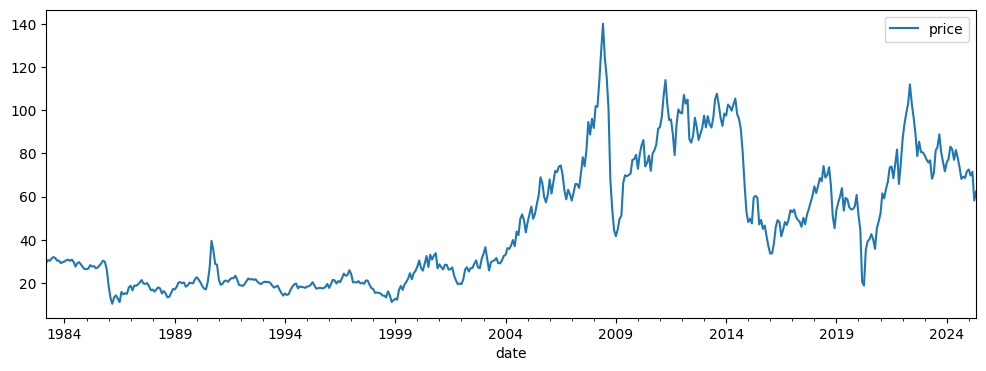

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('/content/crude-oil-price.csv',index_col='date', parse_dates=True, usecols=['date', 'price'])
df.index.freq = 'MS'

df.plot(figsize=(12, 4))

#3. CHECK THE MISSING VALUES

In [96]:
print(df.isnull().sum())

# start_date = '1985-01-01'
# end_date = '2000-01-01'
# df = df[(df.index >= start_date) & (df.index <= end_date)]
# df.plot(figsize=(12, 4))

price    0
dtype: int64


#4. TIME SERIES DECOMPOSITION

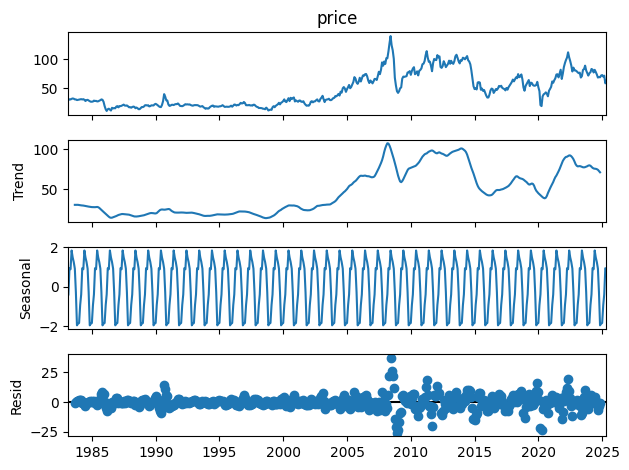

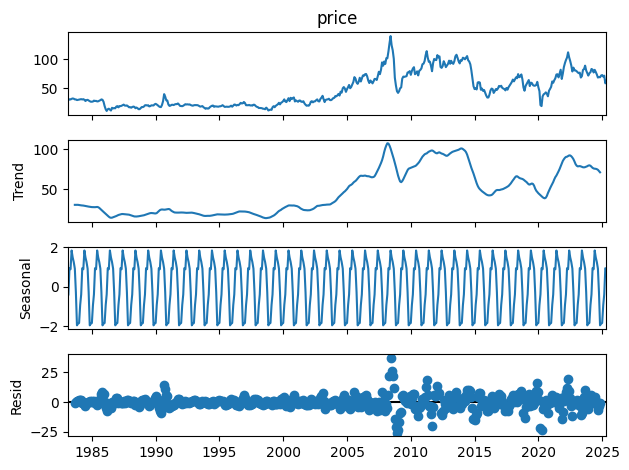

In [97]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df['price'])
decompose.plot()

#5. TRAIN-TEST SPLIT

In [98]:
total_size = len(df)
# test_size = int(len(df)*0.15)
test_size = 12

train_set = df[:total_size-test_size]
test_set = df[total_size-test_size:]

#5. DATA SCALING

In [99]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_set)
scaled_train_set = scaler.transform(train_set)
scaled_test_set = scaler.transform(test_set)

#6. SEQUENCE GENERATION FOR LSTM

In [100]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 18 # 18
n_features = 1
generator = TimeseriesGenerator(scaled_train_set, scaled_train_set,
                                length=n_input, batch_size=1) # 1

#7. LSTM MODEL CONSTRUCTION

In [101]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(n_input, n_features))) # 32
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [102]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

# 8. MODEL TRAINING

In [103]:
model.fit(generator, epochs=5) # 10

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


477/477 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0159
Epoch 2/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050
Epoch 3/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055
Epoch 4/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032
Epoch 5/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0034


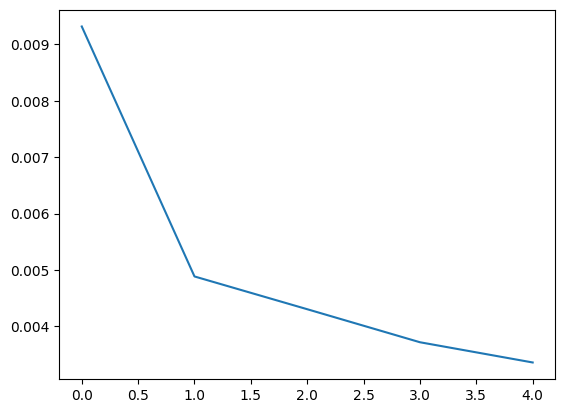

In [104]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [105]:
last_train_batch = scaled_train_set[-n_input:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


array([[0.5009131]], dtype=float32)

#9. FORECASTING AND PREDICTIONS

In [106]:
test_predictions = []
first_eval_batch = scaled_train_set[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test_set)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [107]:
true_predictions = scaler.inverse_transform(test_predictions)

In [108]:
test_set['Predictions'] = true_predictions

<ipython-input-108-22ce99fad483>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Predictions'] = true_predictions


<Axes: xlabel='date'>

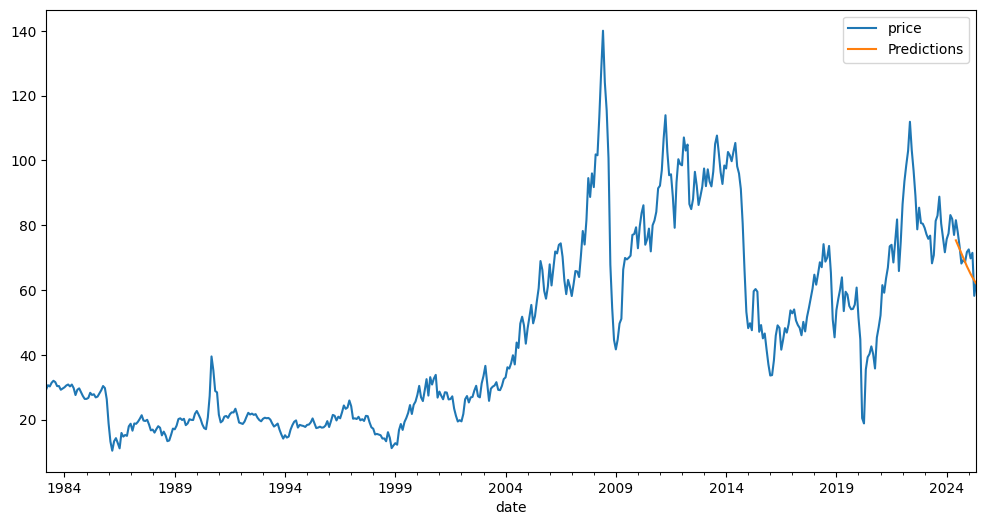

In [109]:
full_set = pd.concat([train_set, test_set])
full_set.plot(figsize=(12, 6))

#10. MODEL EVALUATION

In [110]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(test_set['price'], test_set['Predictions']))
print(rmse)
print("#"*32)
print(test_set)

4.358564419943234
################################
                             price  Predictions
date                                           
2024-06-01 00:00:00+00:00  81.5400    75.328317
2024-07-01 00:00:00+00:00  77.9100    73.985567
2024-08-01 00:00:00+00:00  73.5500    72.617140
2024-09-01 00:00:00+00:00  68.1700    71.242398
2024-10-01 00:00:00+00:00  69.2600    69.888395
2024-11-01 00:00:00+00:00  68.6300    68.579196
2024-12-01 00:00:00+00:00  71.7200    67.310769
2025-01-01 00:00:00+00:00  72.5300    66.104672
2025-02-01 00:00:00+00:00  69.7600    64.978830
2025-03-01 00:00:00+00:00  71.4800    63.928911
2025-04-01 00:00:00+00:00  58.2100    62.966049
2025-05-01 00:00:00+00:00  62.2914    62.075000


#11. MODEL SAVING

In [111]:
model.save('model.keras')

# PREDICTION PRICE FOR 2026



In [112]:
# retrain the model with the test dataset
forecast = []
scaled_full_set = np.concatenate((scaled_train_set, scaled_test_set))

full_generator = TimeseriesGenerator(scaled_full_set, scaled_full_set,
                                length=n_input, batch_size=1)

model.fit(full_generator, epochs=4)

Epoch 1/4
 43/489 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0032
Epoch 2/4
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0024
Epoch 3/4
489/489 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028
Epoch 4/4
489/489 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0020


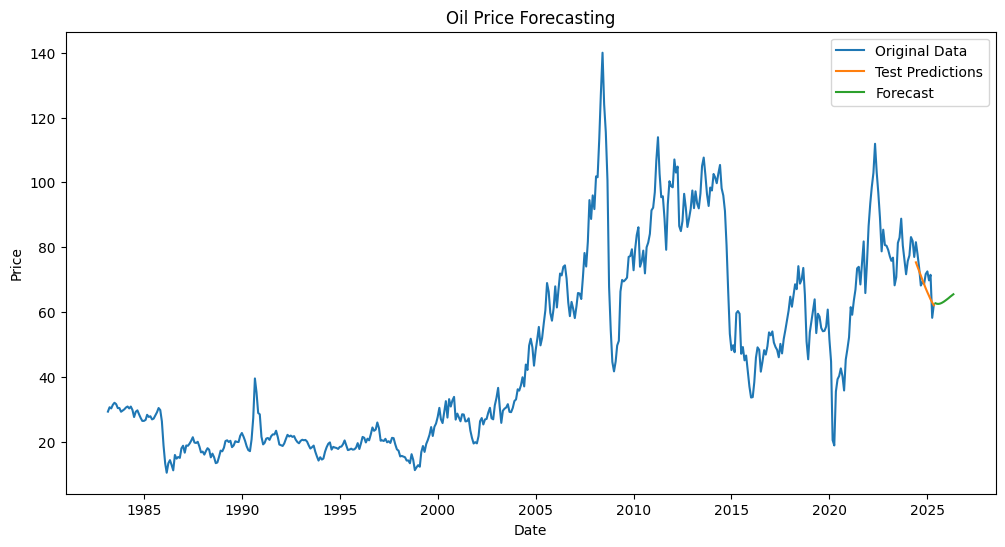

################################
12 Month Forecast:
                            Forecast
2025-06-01 00:00:00+00:00  62.696484
2025-07-01 00:00:00+00:00  62.526180
2025-08-01 00:00:00+00:00  62.510972
2025-09-01 00:00:00+00:00  62.633684
2025-10-01 00:00:00+00:00  62.861777
...
                            Forecast
2026-01-01 00:00:00+00:00  63.897422
2026-02-01 00:00:00+00:00  64.294993
2026-03-01 00:00:00+00:00  64.696623
2026-04-01 00:00:00+00:00  65.093707
2026-05-01 00:00:00+00:00  65.478205


In [113]:
# predict

first_forecast_batch = scaled_full_set[-n_input:]

current_batch = first_forecast_batch.reshape((1, n_input, n_features))

# Predict the next 48 months (as specified in the original code)
for i in range(12):
    current_pred = model.predict(current_batch, verbose=0)[0] # Added verbose=0 to reduce output
    forecast.append(current_pred)
    # Update the current_batch to include the prediction and drop the oldest value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

# Inverse transform the forecast
forecast = scaler.inverse_transform(forecast)

# Create a date index for the forecast
last_date = df.index[-1]
# The forecast starts from the month *after* the last date in the original df
forecast_index = pd.date_range(start=last_date, periods=len(forecast) + 1, freq='MS')[1:]

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])

# Plot the original data, test set with predictions, and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['price'], label='Original Data')
plt.plot(test_set['Predictions'], label='Test Predictions') # Keep test predictions for comparison
plt.plot(forecast_df['Forecast'], label='Forecast') # Changed label to 'Forecast'
plt.title('Oil Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print("#"*32)
print(f"{len(forecast)} Month Forecast:") # Print the actual number of months forecasted
print(forecast_df.head()) # Print the first few months of the forecast
print("...")
print(forecast_df.tail()) # Print the last few months of the forecast